## Create code that processes model output into nice visualizations:

1) The files with daily cases, hospital, deaths counts across all population per districts with format output_workplaceBubblesSophie_ need to be averaged for daily trajectories
2) The files with daily cases, deaths, and in occupation by occupation (occ4) with format output_workplaceBubblesSophie_1_Economic_Status_Covid need to be averaged for daily trajectories
3) The files with daily demographics of cases and deaths by sex and gender

In [44]:
# generic packages
import os
from os.path import isfile, join
import glob
import subprocess
import re

#dataframe packages
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# plot packages
import matplotlib as mpl
import matplotlib.pyplot as plt
import pylab as plt
import seaborn as sns
sns.set(style="darkgrid")

#maps
import geopandas as gpd
import plotly.express as px
import json


In [45]:

demo_input_path= "/Users/sophieayling/Library/CloudStorage/GoogleDrive-sophie2ayling@gmail.com/My Drive/PhD/06_Data and Modelling/thesis_data/model_output/c_demographics/"
demo_denom_input= "/Users/sophieayling/Library/CloudStorage/GoogleDrive-sophie2ayling@gmail.com/My Drive/PhD/06_Data and Modelling/thesis_data/model_output/c_demographics/denominators/"
demo_output_path= "/Users/sophieayling/Library/CloudStorage/GoogleDrive-sophie2ayling@gmail.com/My Drive/PhD/06_Data and Modelling/thesis_data/model_output/c_demographics/plots/"


# try the loop 

prefix_pairs = [
    ('output_workplaceBubblesSophie_', 'bubblesNorm'),
    ('output_perfectMixingSophie_', 'perfMix'),
    ('output_schoolToHomeSophie_', 'schoolToHome'),
    ('output_schoolToComSophie_', 'schoolToCom'),
    ('output_comWorkToHomeSophie_', 'comWorkersToHome'),
    ('output_workToHomeSophie_', 'workToHome'),
    ('output_allToHomeSophie_', 'allToHome'),
    ('output_BubblesLd_', 'bubblesLd_'),
    ('output_BubblesLd1a_', 'bubblesLd_1a'),
    ('output_BubblesLd1b_', 'bubblesLd_1b'),
    ('output_BubblesLd2a_', 'bubblesLd_2a'),
    ('output_BubblesLd2b_', 'bubblesLd_2b'),
    ('output_BubblesLd3a_', 'bubblesLd_3a'),
    ('output_BubblesLd3b_', 'bubblesLd_3b')
]


## script code for deaths

In [47]:


for file_prefix, id_prefix in prefix_pairs:
    # Use glob to find all files with the specified prefix
    file_pattern = f"{folder_path}/{file_prefix}*.txt"
    file_list = glob.glob(file_pattern)

    # Initialize an empty list to store individual DataFrames
    df_list = []

    # Loop through the list of files and read each one into a DataFrame
    for file in file_list:
        df = pd.read_csv(file, delimiter='\t')# Adjust delimiter as per your file format
        # Extract the run number from the filename
        run_number = os.path.basename(file).split('_')[-5].split('.')[0]
        df['run']=run_number
        df_list.append(df)

    # Concatenate all DataFrames in the list into a single DataFrame
    final_df = pd.concat(df_list, ignore_index=True)
    # Convert the 'run_number' column to numeric (int64)
    final_df['run'] = pd.to_numeric(final_df['run'])
    # Display the resulting DataFrame
    nan_rows = final_df[final_df.isna().any(axis=1)]
    final_df.head()
    output_df=final_df.set_index('day')
    output_df.to_csv(demo_output_path+f'{id_prefix}aggregate_demo_df.csv', index=True)
    output_df.head()

    # add up over the age rows into the categories I think make sense 
    final_df['<10']= final_df['<1']+final_df['5_9']
    final_df['10<19']=final_df['10_14']+final_df['15_19']
    final_df['20<29']=final_df['20_24']+final_df['25_29']
    final_df['30<39']=final_df['30_34']+final_df['35_39']
    final_df['40<49']=final_df['40_44']+final_df['45_49']
    final_df['50<59']=final_df['50_54']+final_df['55_59']
    final_df['60<69']=final_df['60_64']+final_df['65_69']
    final_df['70<79']=final_df['70_74']+final_df['75_79']
    final_df['80 and over']=final_df['80_84']+final_df['85_89']+final_df['90_94']+final_df['95<']
    final_df=final_df.drop(columns=['<1', '1_4','5_9','10_14','15_19', '20_24','25_29','30_34', '35_39','40_44', '45_49','50_54','55_59', '60_64', '65_69','70_74', '75_79', '80_84', '85_89',  '90_94', '95<'  ])

    #first take only deaths but keeping runs independent, grouping male and female for each age category
    d_data = final_df[final_df['metric']=='deaths']

    # Columns to compute cumulative sums for
    columns_to_sum = ['<10', '10<19', '20<29', '30<39', '40<49', '50<59', '60<69', '70<79', '80 and over']

    # Sort the DataFrame by 'day'
    d_data = d_data.sort_values(by=['run', 'day'])

    # First group by gender
    d_data = d_data.groupby(['run', 'day']). sum().reset_index()

    # Sort the DataFrame by 'day' and 'run'
    d_data_sorted = d_data.sort_values(by=['day', 'run'])

    # Take the average deaths per day across runs 
    d_data_sorted= d_data_sorted.drop(columns=['metric','sex'])

    d_data_sorted.set_index('day', inplace=True)

    d_data_sorted = d_data_sorted.groupby('day').mean().reset_index()

    d_data_sorted= d_data_sorted.drop(columns='run')

    d_data_sorted.to_csv(demo_output_path+f'{id_prefix}av_demo_deaths_noncum.csv', index=False)
    d_data_sorted.head()

    # compute cumulative sums

    # Compute cumulative sums for each column
    cumsum_data = d_data_sorted[columns_to_sum].cumsum()


    # # Group by 'day' and 'run' and aggregate using sum
    d_data_sorted=d_data_sorted.groupby('day').mean(columns_to_sum).reset_index()


    # Combine the cumulative sum data with the original 'run' and 'day' columns
    d_data_sorted_cs = pd.concat([d_data_sorted['day'], cumsum_data], axis=1)


    # # Reorder the columns so 'day' and 'run' are first
    # cols = ['day', 'run'] + [col for col in d_data_sorted.columns if col not in ['day', 'run']]
    # d_data_sorted = d_data_sorted[cols]

    d_data_sorted_cs.to_csv(demo_output_path+f'{id_prefix}cs_demo_deaths.csv', index=False)
    d_data_sorted_cs.head()
    # the death data is already aggregated by day 

    # Find the row with the maximum values for the table 
    max_peak_10 = d_data_sorted_cs[d_data_sorted_cs['<10']==d_data_sorted_cs['<10'].max()]
    max_peak_19 = d_data_sorted_cs[d_data_sorted_cs['10<19']==d_data_sorted_cs['10<19'].max()]
    max_peak_29 = d_data_sorted_cs[d_data_sorted_cs['20<29']==d_data_sorted_cs['20<29'].max()]
    max_peak_39 = d_data_sorted_cs[d_data_sorted_cs['30<39']==d_data_sorted_cs['30<39'].max()]
    max_peak_49 = d_data_sorted_cs[d_data_sorted_cs['40<49']==d_data_sorted_cs['40<49'].max()]
    max_peak_59 = d_data_sorted_cs[d_data_sorted_cs['50<59']==d_data_sorted_cs['50<59'].max()]
    max_peak_69 = d_data_sorted_cs[d_data_sorted_cs['60<69']==d_data_sorted_cs['60<69'].max()]
    max_peak_79 = d_data_sorted_cs[d_data_sorted_cs['70<79']==d_data_sorted_cs['70<79'].max()]
    max_peak_o80 = d_data_sorted_cs[d_data_sorted_cs['80 and over']==d_data_sorted_cs['80 and over'].max()]


    # Print the row
    max_peak_o80.to_csv(demo_output_path+f'_deaths_o80s{id_prefix}.csv')
    max_peak_o80.head()

## script code for cases

In [49]:
# something weird, don't use it. 

# for file_prefix, id_prefix in prefix_pairs:
#     # for case data it will be non-cumulative
#     #first take only cases but keeping runs independent, grouping male and female for each age category
#     c_data = final_df[final_df['metric']=='cases']


#     c_data.to_csv (demo_output_path+'agg_case_counts_demo.csv')
#     c_data.head()

#     # Columns to compute cumulative sums for
#     columns_to_sum = ['<10', '10<19', '20<29', '30<39', '40<49', '50<59', '60<69', '70<79', '80 and over']

#     # Sort the DataFrame within runs, by day
#     c_data = c_data.sort_values(by=['run', 'day'])

#     # First group by gender
#     c_data = c_data.groupby(['run', 'day']). sum().reset_index()

#     # Group by 'day' and 'run' and aggregate using sum

#     c_data.to_csv(demo_output_path+'aggregate_demo_cases_noncum.csv', index=False)
#     c_data.head()


#     # Sort the DataFrame within runs, by day
#     c_data_sorted = c_data.sort_values(by=['run', 'day'])

#     # Compute cumulative sums for each column
#     cumsum_data = c_data_sorted[columns_to_sum].cumsum()

#     # Combine the cumulative sum data with the original 'run' and 'day' columns
#     c_data_sorted_cs = pd.concat([c_data_sorted[['run', 'day']], cumsum_data], axis=1)


#     # Reorder the columns so 'day' and 'run' are first
#     cols = ['run', 'day'] + [col for col in c_data_sorted.columns if col not in ['day', 'run']]
#     c_data_sorted = c_data_sorted[cols]

#     c_data_sorted_cs.to_csv(demo_output_path+f'{id_prefix}cs_demo_cases.csv', index=False)

#     c_data_sorted=c_data_sorted.drop(columns=['metric', 'sex'])
#     c_data_sorted_cs.head()
    
#     #group the data by daily national cases (aggregating districts) and runs for the meanmary stats 
#     c_data_sorted_2 = c_data_sorted.groupby('day', as_index=False).mean()

#     #c_data_sorted_2['metric_new_cases_sympt'] = pd.to_numeric(c_data_sorted_2['metric_new_cases_sympt'])
#     #r_data.set_index('time', inplace=True)
#     c_data_sorted_2.to_csv (demo_output_path+f'{id_prefix}_cs2_demo_cases.csv')
#     c_data_sorted_2.head()

#     # Find the row with the maximum values for the table 
#     max_peak_10 = c_data_sorted_2[c_data_sorted_2['<10']==c_data_sorted_2['<10'].max()]
#     max_peak_19 = c_data_sorted_2[c_data_sorted_2['10<19']==c_data_sorted_2['10<19'].max()]
#     max_peak_29 = c_data_sorted_2[c_data_sorted_2['20<29']==c_data_sorted_2['20<29'].max()]
#     max_peak_39 = c_data_sorted_2[c_data_sorted_2['30<39']==c_data_sorted_2['30<39'].max()]
#     max_peak_49 = c_data_sorted_2[c_data_sorted_2['40<49']==c_data_sorted_2['40<49'].max()]
#     max_peak_59 = c_data_sorted_2[c_data_sorted_2['50<59']==c_data_sorted_2['50<59'].max()]
#     max_peak_69 = c_data_sorted_2[c_data_sorted_2['60<69']==c_data_sorted_2['60<69'].max()]
#     max_peak_79 = c_data_sorted_2[c_data_sorted_2['70<79']==c_data_sorted_2['70<79'].max()]
#     max_peak_o80 = c_data_sorted_2[c_data_sorted_2['80 and over']==c_data_sorted_2['80 and over'].max()]


#      # Print the row
#     max_peak_29.to_csv(demo_output_path+f'_peak_cases_29{id_prefix}.csv')
#     max_peak_29.head()


In [13]:
# decide which version I am creating graphics for 

# Define the folder path and file prefix
folder_path = demo_input_path


file_prefix = 'output_workplaceBubblesSophie_'
id_prefix='bubblesNorm'

# file_prefix = 'output_perfectMixingSophie_'
# id_prefix="perfMix"

# file_prefix ='output_schoolToHomeSophie_'
# id_prefix = "schoolToHome"

# file_prefix ='output_schoolToComSophie_'
# id_prefix = "schoolToCom"

# file_prefix ='output_comWorkToHomeSophie_'
# id_prefix = "comWorkersToHome"

# file_prefix = 'output_workToHomeSophie_'
# id_prefix = 'workToHome'

# file_prefix = 'output_allToHomeSophie_'
# id_prefix = 'allToHome'

# ## mobility scenarios set 
# file_prefix = 'output_BubblesLd_'
# id_prefix = 'bubblesLd'

# file_prefix = 'output_BubblesLd_'
# id_prefix = 'bubblesLdv2'

# file_prefix = 'output_BubblesLd1a_'
# id_prefix = 'bubblesLd_1a'

# file_prefix = 'output_BubblesLd1b_'
# id_prefix = 'bubblesLd_1b'

# file_prefix = 'output_BubblesLd2a_'
# id_prefix = 'bubblesLd_2a'

# file_prefix = 'output_BubblesLd2b_'
# id_prefix = 'bubblesLd_2b'

# file_prefix = 'output_BubblesLd3a_'
# id_prefix = 'bubblesLd_3a'

# file_prefix = 'output_BubblesLd3b_'
# id_prefix = 'bubblesLd_3b'



### 1. Case counts version

In [14]:

# Use glob to find all files with the specified prefix
file_pattern = f"{folder_path}/{file_prefix}*.txt"
file_list = glob.glob(file_pattern)

# Initialize an empty list to store individual DataFrames
df_list = []

# Loop through the list of files and read each one into a DataFrame
for file in file_list:
    df = pd.read_csv(file, delimiter='\t')# Adjust delimiter as per your file format
    # Extract the run number from the filename
    run_number = os.path.basename(file).split('_')[-5].split('.')[0]
    df['run']=run_number
    df_list.append(df)

# Concatenate all DataFrames in the list into a single DataFrame
final_df = pd.concat(df_list, ignore_index=True)
# Convert the 'run_number' column to numeric (int64)
final_df['run'] = pd.to_numeric(final_df['run'])
# Display the resulting DataFrame
nan_rows = final_df[final_df.isna().any(axis=1)]
final_df.head()
output_df=final_df.set_index('day')
output_df.to_csv(demo_output_path+f'{id_prefix}aggregate_demo_df.csv', index=True)
output_df.head()

,metric,sex,<1,1_4,5_9,10_14,15_19,20_24,25_29,30_34,...,55_59,60_64,65_69,70_74,75_79,80_84,85_89,90_94,95<,run
day,,,,,,,,,,,,,,,,,,,,,
0,cases,m,0,1,1,4,0,0,0,2,...,1,1,0,0,0,0,0,0,0,3
0,deaths,m,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
0,cases,f,1,1,0,1,0,1,1,0,...,0,0,0,0,1,0,0,0,0,3
0,deaths,f,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
1,cases,m,0,1,1,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,3


### 2. Cumulative deaths by age

#### Non-cumulative first 

In [15]:
# add up over the age rows into the categories I think make sense 
final_df['<10']= final_df['<1']+final_df['5_9']
final_df['10<19']=final_df['10_14']+final_df['15_19']
final_df['20<29']=final_df['20_24']+final_df['25_29']
final_df['30<39']=final_df['30_34']+final_df['35_39']
final_df['40<49']=final_df['40_44']+final_df['45_49']
final_df['50<59']=final_df['50_54']+final_df['55_59']
final_df['60<69']=final_df['60_64']+final_df['65_69']
final_df['70<79']=final_df['70_74']+final_df['75_79']
final_df['80 and over']=final_df['80_84']+final_df['85_89']+final_df['90_94']+final_df['95<']
final_df=final_df.drop(columns=['<1', '1_4','5_9','10_14','15_19', '20_24','25_29','30_34', '35_39','40_44', '45_49','50_54','55_59', '60_64', '65_69','70_74', '75_79', '80_84', '85_89',  '90_94', '95<'  ])

#first take only deaths but keeping runs independent, grouping male and female for each age category
d_data = final_df[final_df['metric']=='deaths']

# Columns to compute cumulative sums for
columns_to_sum = ['<10', '10<19', '20<29', '30<39', '40<49', '50<59', '60<69', '70<79', '80 and over']

# Sort the DataFrame by 'day'
d_data = d_data.sort_values(by=['run', 'day'])

# First group by gender
d_data = d_data.groupby(['run', 'day']). sum().reset_index()

# Sort the DataFrame by 'day' and 'run'
d_data_sorted = d_data.sort_values(by=['day', 'run'])

# Take the average deaths per day across runs 
d_data_sorted= d_data_sorted.drop(columns=['metric','sex'])

d_data_sorted.set_index('day', inplace=True)

d_data_sorted = d_data_sorted.groupby('day').mean().reset_index()

d_data_sorted= d_data_sorted.drop(columns='run')

d_data_sorted.to_csv(demo_output_path+f'{id_prefix}av_demo_deaths_noncum.csv', index=False)
d_data_sorted.head()

# compute cumulative sums 


,day,<10,10<19,20<29,30<39,40<49,50<59,60<69,70<79,80 and over
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Cumulative sums of deaths (after averaging across runs)

In [16]:

# Compute cumulative sums for each column
cumsum_data = d_data_sorted[columns_to_sum].cumsum()


# # Group by 'day' and 'run' and aggregate using sum
d_data_sorted=d_data_sorted.groupby('day').mean(columns_to_sum).reset_index()


# Combine the cumulative sum data with the original 'run' and 'day' columns
d_data_sorted_cs = pd.concat([d_data_sorted['day'], cumsum_data], axis=1)

    
# # Reorder the columns so 'day' and 'run' are first
# cols = ['day', 'run'] + [col for col in d_data_sorted.columns if col not in ['day', 'run']]
# d_data_sorted = d_data_sorted[cols]

d_data_sorted_cs.to_csv(demo_output_path+f'{id_prefix}cs_demo_deaths.csv', index=False)
d_data_sorted_cs.head()





,day,<10,10<19,20<29,30<39,40<49,50<59,60<69,70<79,80 and over
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
# the death data is already aggregated by day 

# Find the row with the maximum values for the table 
max_peak_10 = d_data_sorted_cs[d_data_sorted_cs['<10']==d_data_sorted_cs['<10'].max()]
max_peak_19 = d_data_sorted_cs[d_data_sorted_cs['10<19']==d_data_sorted_cs['10<19'].max()]
max_peak_29 = d_data_sorted_cs[d_data_sorted_cs['20<29']==d_data_sorted_cs['20<29'].max()]
max_peak_39 = d_data_sorted_cs[d_data_sorted_cs['30<39']==d_data_sorted_cs['30<39'].max()]
max_peak_49 = d_data_sorted_cs[d_data_sorted_cs['40<49']==d_data_sorted_cs['40<49'].max()]
max_peak_59 = d_data_sorted_cs[d_data_sorted_cs['50<59']==d_data_sorted_cs['50<59'].max()]
max_peak_69 = d_data_sorted_cs[d_data_sorted_cs['60<69']==d_data_sorted_cs['60<69'].max()]
max_peak_79 = d_data_sorted_cs[d_data_sorted_cs['70<79']==d_data_sorted_cs['70<79'].max()]
max_peak_o80 = d_data_sorted_cs[d_data_sorted_cs['80 and over']==d_data_sorted_cs['80 and over'].max()]


# Print the row
max_peak_o80.to_csv(demo_output_path+f'_deaths_o80s{id_prefix}.csv)
max_peak_o80.head()


,day,<10,10<19,20<29,30<39,40<49,50<59,60<69,70<79,80 and over
89,89,0.8,2.7,14.4,30.2,48.4,98.4,175.0,318.0,750.9
90,90,0.8,2.7,14.4,30.3,48.4,98.4,175.0,318.0,750.9
91,91,0.8,2.7,14.4,30.3,48.4,98.4,175.0,318.0,750.9
92,92,0.8,2.7,14.4,30.3,48.4,98.4,175.0,318.0,750.9
93,93,0.8,2.7,14.5,30.3,48.4,98.4,175.0,318.1,750.9


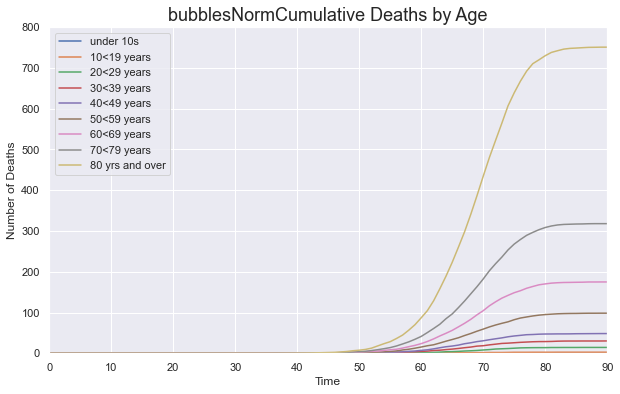

In [17]:

# Plotting the data
plt.figure(figsize=(10, 6))
sns.lineplot(data=d_data_sorted_cs, x="day", y="<10", ci='sd', label="under 10s") 
sns.lineplot(data=d_data_sorted_cs, x="day", y="10<19", ci='sd', label="10<19 years")
sns.lineplot(data=d_data_sorted_cs, x="day", y="20<29", ci='sd', label="20<29 years") 
sns.lineplot(data=d_data_sorted_cs, x="day", y="30<39", ci='sd', label="30<39 years")
sns.lineplot(data=d_data_sorted_cs, x="day", y="40<49", ci='sd', label="40<49 years") 
sns.lineplot(data=d_data_sorted_cs, x="day", y="50<59", ci='sd', label="50<59 years") 
sns.lineplot(data=d_data_sorted_cs, x="day", y="60<69", ci='sd', label="60<69 years")
sns.lineplot(data=d_data_sorted_cs, x="day", y="70<79", ci='sd', label="70<79 years") 
sns.lineplot(data=d_data_sorted_cs, x="day", y="80 and over", ci='sd', label="80 yrs and over") 


# Adding titles and labels
plt.title(f'{id_prefix}Cumulative Deaths by Age', size=18)
plt.xlabel('Time')
plt.ylabel('Number of Deaths')
plt.xlim(0,90)
plt.ylim(0,800)
plt.grid(True)

# export the plot 
plt.savefig(demo_output_path+f'{id_prefix}deaths_over_time_err.png', dpi=300, facecolor="white")


# Case plots by age

In [25]:
# for case data it will be non-cumulative
#first take only cases but keeping runs independent, grouping male and female for each age category
c_data = final_df[final_df['metric']=='cases']


c_data.to_csv (demo_output_path+'agg_case_counts_demo.csv')
c_data.head()

# Columns to compute cumulative sums for
columns_to_sum = ['<10', '10<19', '20<29', '30<39', '40<49', '50<59', '60<69', '70<79', '80 and over']

# Sort the DataFrame within runs, by day
c_data = c_data.sort_values(by=['run', 'day'])

# First group by gender
c_data = c_data.groupby(['run', 'day']). sum().reset_index()

# Group by 'day' and 'run' and aggregate using sum

c_data.to_csv(demo_output_path+'aggregate_demo_cases_noncum.csv', index=False)
c_data.head()


# Sort the DataFrame within runs, by day
c_data_sorted = c_data.sort_values(by=['run', 'day'])

# Compute cumulative sums for each column
cumsum_data = c_data_sorted[columns_to_sum].cumsum()

# Combine the cumulative sum data with the original 'run' and 'day' columns
c_data_sorted_cs = pd.concat([c_data_sorted[['run', 'day']], cumsum_data], axis=1)

    
# Reorder the columns so 'day' and 'run' are first
cols = ['run', 'day'] + [col for col in c_data_sorted.columns if col not in ['day', 'run']]
c_data_sorted = c_data_sorted[cols]

c_data_sorted_cs.to_csv(demo_output_path+f'{id_prefix}cs_demo_cases.csv', index=False)

c_data_sorted=c_data_sorted.drop(columns=['metric', 'sex'])
c_data_sorted_cs.head()


,run,day,<10,10<19,20<29,30<39,40<49,50<59,60<69,70<79,80 and over
0,1,0,3,3,7,0,1,2,0,0,1
1,1,1,5,7,10,3,4,3,0,0,1
2,1,2,7,9,14,4,6,3,0,0,1
3,1,3,7,10,18,8,8,3,0,1,1
4,1,4,7,11,25,8,8,3,0,1,1


In [51]:
#group the data by daily national cases (aggregating districts) and runs for the meanmary stats 
c_data_sorted_2 = c_data_sorted.groupby('day', as_index=False).mean()

#c_data_sorted_2['metric_new_cases_sympt'] = pd.to_numeric(c_data_sorted_2['metric_new_cases_sympt'])
#r_data.set_index('time', inplace=True)
c_data_sorted_2.to_csv (demo_output_path+f'{id_prefix}_cs2_demo_cases.csv')


# Find the row with the maximum values for the table 
max_peak_10 = c_data_sorted_2[c_data_sorted_2['<10']==c_data_sorted_2['<10'].max()]
max_peak_19 = c_data_sorted_2[c_data_sorted_2['10<19']==c_data_sorted_2['10<19'].max()]
max_peak_29 = c_data_sorted_2[c_data_sorted_2['20<29']==c_data_sorted_2['20<29'].max()]
max_peak_39 = c_data_sorted_2[c_data_sorted_2['30<39']==c_data_sorted_2['30<39'].max()]
max_peak_49 = c_data_sorted_2[c_data_sorted_2['40<49']==c_data_sorted_2['40<49'].max()]
max_peak_59 = c_data_sorted_2[c_data_sorted_2['50<59']==c_data_sorted_2['50<59'].max()]
max_peak_69 = c_data_sorted_2[c_data_sorted_2['60<69']==c_data_sorted_2['60<69'].max()]
max_peak_79 = c_data_sorted_2[c_data_sorted_2['70<79']==c_data_sorted_2['70<79'].max()]
max_peak_o80 = c_data_sorted_2[c_data_sorted_2['80 and over']==c_data_sorted_2['80 and over'].max()]


# # Print the row
# max_peak_o80.head()
c_data_sorted_2.head()

,day,run,<10,10<19,20<29,30<39,40<49,50<59,60<69,70<79,80 and over
0,0,5.5,1.6,2.7,4.0,3.9,1.4,0.9,0.8,0.5,0.1
1,1,5.5,1.0,2.9,3.2,1.9,1.2,0.6,0.4,0.1,0.0
2,2,5.5,1.0,2.0,3.4,1.8,1.4,0.3,0.3,0.1,0.0
3,3,5.5,0.6,2.2,2.4,2.4,1.2,1.1,0.4,0.2,0.2
4,4,5.5,0.3,1.2,2.9,1.0,0.7,0.3,0.2,0.1,0.0


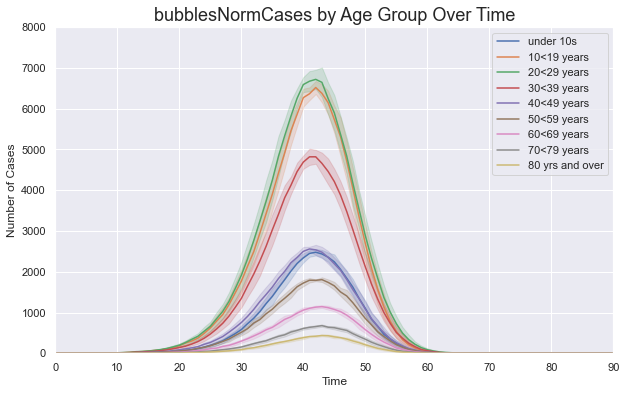

In [19]:
# Plotting the data
plt.figure(figsize=(10, 6))
sns.lineplot(data=c_data_sorted, x="day", y="<10", ci='sd',label="under 10s") 
sns.lineplot(data=c_data_sorted, x="day", y="10<19", ci='sd', label="10<19 years")
sns.lineplot(data=c_data_sorted, x="day", y="20<29",ci='sd', label="20<29 years") 
sns.lineplot(data=c_data_sorted, x="day", y="30<39", ci='sd', label="30<39 years")
sns.lineplot(data=c_data_sorted, x="day", y="40<49", ci='sd',label="40<49 years") 
sns.lineplot(data=c_data_sorted, x="day", y="50<59", ci='sd', label="50<59 years") 
sns.lineplot(data=c_data_sorted, x="day", y="60<69", ci='sd', label="60<69 years")
sns.lineplot(data=c_data_sorted, x="day", y="70<79",  ci='sd', label="70<79 years") 
sns.lineplot(data=c_data_sorted, x="day", y="80 and over", ci='sd', label="80 yrs and over") 


# Adding titles and labels
plt.title(f'{id_prefix}Cases by Age Group Over Time', size=18)
plt.xlabel('Time')
plt.ylabel('Number of Cases')
plt.xlim(0,90)
plt.ylim(0,8000)
plt.grid(True)

# export the plot 
plt.savefig(demo_output_path+f'{id_prefix}cases_over_time.png', dpi=300, facecolor="white")

### make another two plots of proportions of age groups with cases and deaths

In [10]:
## melt the age categories 

c_data_sorted_cs.head()


,run,day,<10,10<19,20<29,30<39,40<49,50<59,60<69,70<79,80 and over
0,1,0,3,3,7,0,1,2,0,0,1
1,1,1,5,7,10,3,4,3,0,0,1
2,1,2,7,9,14,4,6,3,0,0,1
3,1,3,7,10,18,8,8,3,0,1,1
4,1,4,7,11,25,8,8,3,0,1,1
